Treinando uma rede neural
=========================



## Introdução



Depois de uma longa jornada, finalmente chegamos ao *season finale* da nossa saga para construir uma rede neural artificial em Python puro. Agora que já conseguimos criar uma rede neural, o próximo passo é treinar essa rede.



## Objetivo



Treinar uma rede neural artificial tipo Multilayer Perceptron usando Python.



## Importações



In [1]:
import random
from classes import Valor
from funcoes import plota_grafo

## Código e discussão



### Classes



Abaixo estão as classes que criamos no notebook anterior. Elas são as classes de base para criarmos nossa rede neural MLP. Ao longo deste notebook vamos fazer as últimas modificações nelas.



In [2]:
class Neuronio:
    def __init__(self, num_dados_entrada):
        pesos = []

        for _ in range(num_dados_entrada):
            peso = Valor(random.uniform(-1, 1))
            pesos.append(peso)

        self.pesos = pesos # Instancia de valor
        self.vies = Valor(random.uniform(-1, 1)) # Instancia de valor

    def __call__(self, x):
        """Executa a computação interna do neurônio.

        Args:
          x: lista de valores de entrada (informação que chega ao neurônio).

        Returns:
          Informação que o neurônio propaga adiante. Trata-se da
          aplicação da função de ativação à soma de `x` vezes os pesos do
          neurônio adicionado ao viés.
        """
        assert len(x) == len(self.pesos), "Seu x tem tamanho errado."

        soma = 0
        for x_, p in zip(x, self.pesos):
            soma = soma + x_ * p

        soma = soma + self.vies
        dado_de_saida = soma.sig()
        return dado_de_saida
    
    def parametros(self):
        return self.pesos + [self.vies] # Cada neurônio recebe uma informação, onde a informação passará por uma função e será atribuído a um viés.
                                        # Os parâmetros em um neurônio, que compreendem pesos, função e viés, serão apenas os pesos e viés, pois não mudamos a função.
    
    # O método parâmetros irá buscar por toda a rede os dados que são parâmetros(podem ser alterados)


class Camada:
    def __init__(self, num_dados_entrada, num_neuronios):
        neuronios = []

        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)

        self.neuronios = neuronios

    def __call__(self, x):
        """Executa a computação de cada neurônio da camada.

        Args:
          x: lista de valores de entrada (informação que chega aos neurônios).

        Returns:
          Informação que os neurônios da camada propagam adiante.
        """
        saidas = []

        for neuronio in self.neuronios:
            informacao = neuronio(x)
            saidas.append(informacao)

        if len(saidas) == 1:
            return saidas[0]
        else:
            return saidas
        
    def parametros(self):        
        params = []

        for neuronio in self.neuronios:
            params.extend(neuronio.parametros()) # .extend e não .append pois são várias listas. O extend pega a lista params, e pega os elementos da lista de neuronios e coloca na lista params.
        return params


class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):

        percurso = [num_dados_entrada] + num_neuronios_por_camada
        camadas = []

        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(percurso[i], percurso[i+1])
            camadas.append(camada)

        self.camadas = camadas

    def __call__(self, x):
        """Executa a computação de cada camada.

        Como a rede MLP é uma rede feedforward, a informação que uma camada
        recebe é a informação de saída da camada anterior. A única exceção é a
        camada de entrada, onde a informação é fornecida pelo usuário

        Args:
          x: informação fornecida na camada de entrada.

        Returns:
          Informação recuperada na camada de saída.
        """
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        for camada in self.camadas:
            params.extend(camada.parametros())
        return params

### A função de perda (*loss function*)



Fomos ao laboratório e sintetizamos 4 amostras de [complete com o que quiser]. Cada uma dessas amostras foi feita variando 3 parâmetros de processamento diferentes. Estas amostras e seus parâmetros de processamento estão representados na variável `x` abaixo.

Levamos essas 4 amostras no equipamento [complete com o que quiser] e obtivemos uma resposta que está representada na variável `y_true` abaixo.



In [3]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

Queremos treinar uma MLP que seja capaz de modelar o comportamento que observamos. Isto é, queremos uma rede neural que receba informação sobre os 3 parâmetros de processamento e que com isso seja capaz de prever qual o resultado que teríamos no equipamento que mencionamos no parágrafo anterior.

Vamos, primeiramente, criar uma rede neural simples do tipo MLP.



In [4]:
NUM_DADOS_DE_ENTRADA = 3  # são 3 parâmetros que descrevem cada amostra
NUM_DADOS_DE_SAIDA = 1    # queremos apenas um valor de saída por amostra
CAMADAS_OCULTAS = [3, 2]  # fique à vontade para alterar aqui

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

Com nossa rede criada, podemos realizar uma previsão! Mas muito provavelmente esta previsão será bastante subótima.



In [5]:
# Fazendo um predict do modelo, mas como ainda não treinamos a rede, o valor predito não será o valor esperado

y_pred = []

for x_ in x:
    valor_previsto = minha_mlp(x_)
    y_pred.append(valor_previsto)

print(y_true)
print(y_pred)

[1, 0, 0.2, 0.5]
[Valor(data=0.4912413931155609), Valor(data=0.49111219238126247), Valor(data=0.4854012934036323), Valor(data=0.48890089373667805)]


Nosso resultado, assim como esperado, é bastante subótimo. Mas como quantificar isso? Seria bom se existisse uma forma de quantificar em um único número o quão boa está a previsão da minha rede.

Uma forma de quantificar a qualidade da previsão é usando uma `função de perda`, mais conhecida como `loss function`. Aqui podemos, por exemplo, computar a soma dos erros quadráticos. Esta é uma função de perda muito usada em problemas de regressão.



In [14]:
# Minimizando o erro quadrado dos quadrados mínimos, significa que estamos nos aproximando do valor esperado

erros_quadrados = []

for yt, yp in zip(y_true, y_pred):
    erro_quadratico = (yp - yt) ** 2
    erros_quadrados.append(erro_quadratico)

loss = sum(erros_quadrados) # Dividir por N seria o erro quadrático médio, mas como queremos minimizar, não faz muita diferença calcular a média ou o mínimo
print(loss) # Valor da perda

Valor(data=0.5813764425441151)


A variável `loss` é uma medida da performance da rede neural que criamos. Essa variável é uma instância de `Valor`, logo podemos facilmente observar o grafo computacional desta métrica.



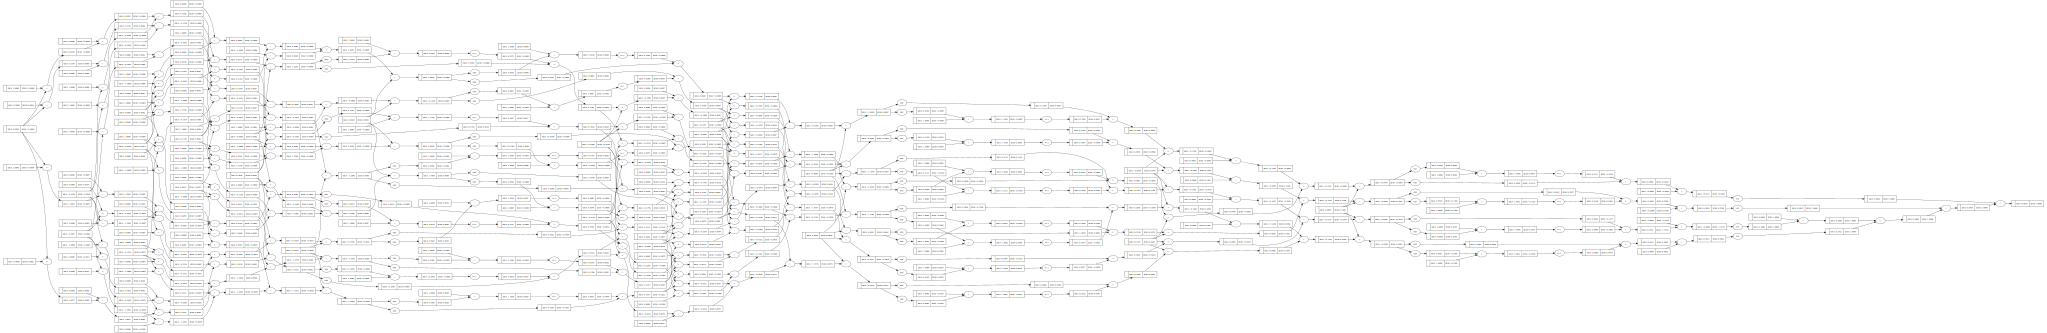

In [7]:
loss.propagar_tudo()
grafo = plota_grafo(loss)
grafo.render("rede_neural", format="png")
grafo

### Treinando a rede através da atualização dos parâmetros



Como vimos acima, o grafo computacional da nossa rede neural é bastante complexo! Cheio de vértices!

Nosso objetivo é treinar a rede neural que criamos, sendo que para isso precisamos alterar os parâmetros internos da rede. O primeiro passo para fazer isso é alterar as nossas classes de forma que o código abaixo funcione.



In [8]:
parametros = minha_mlp.parametros()

#Print da quantidade de parâmetros e seus valores, mas não é mostrado qual parâmetro está sendo mostrado
print(len(parametros))
print()
parametros

23



[Valor(data=0.6292228593426343),
 Valor(data=-0.43639095418077956),
 Valor(data=-0.6248842913708488),
 Valor(data=0.4046983630779195),
 Valor(data=-0.46474685077840583),
 Valor(data=-0.15137584866656595),
 Valor(data=0.09132440041140666),
 Valor(data=-0.5011713013573054),
 Valor(data=0.6868793618684683),
 Valor(data=0.11202453102663212),
 Valor(data=-0.8360335523431843),
 Valor(data=0.260303896771352),
 Valor(data=-0.24694014203135906),
 Valor(data=0.5845508540710194),
 Valor(data=-0.21071803310219117),
 Valor(data=-0.8599802801702778),
 Valor(data=-0.6115813378706387),
 Valor(data=-0.5889589446178372),
 Valor(data=-0.8925250130143063),
 Valor(data=0.920209353179533),
 Valor(data=-0.6917715187504727),
 Valor(data=0.12370195268407747),
 Valor(data=0.08065652671498191)]

Agora que conseguimos &ldquo;extrair&rdquo; os parâmetros da nossa MLP, podemos fazer o treino deles! Temos que pensar bem como alterar os parâmetros da maneira correta. Lembre-se que nosso desejo é reduzir a métrica computada pela função de perda.



In [9]:
TAXA_DE_APRENDIZADO = 0.01

# O gradiente local de cada parametro nos diz a direção (positiva ou negativa)
for p in minha_mlp.parametros():
    p.data = p.data - p.grad * TAXA_DE_APRENDIZADO # Quando temos muitas dimensões (23 no caso) a linearidade do gradiente vai "comer" muitos dados, logo, definimos
                                                   # que não pulamos o gradiente todo, e sim uma pequena parte de cada vez, por isso a variável taxa_de_aprendizado
                                                   # p.data - p.grad reduz a perda devido ao sinal negativo, e a ideia é justamente a redução do erro e não seu aumento.

Agora que executamos um &ldquo;ciclo&rdquo; de treino, podemos observar o impacto disso!



In [16]:
y_pred = []
for x_ in x:
    valor_previsto = minha_mlp(x_)
    y_pred.append(valor_previsto)

erros_quadrados = []
for yt, yp in zip(y_true, y_pred):
    erro_quadratico = (yp - yt) ** 2
    erros_quadrados.append(erro_quadratico)

loss = sum(erros_quadrados)
loss.propagar_tudo()
print(loss) # Fomos na direção correta, pois nosso loss diminuiu quando comparado com o loss anterior mostrado pelos quadrados mínimos

Valor(data=0.5725701636883885)


### A descida do gradiente



Apenas um &ldquo;ciclo&rdquo; de treino costuma não ser suficiente para treinarmos uma rede neural, precisamos de mais! Antes de seguir em frente, vamos definir um termo: chamamos de `época` toda vez que nossa rede neural propaga *todo* nosso dataset. É comum treinarmos redes neurais por dezenas, centenas e até milhares de épocas!

Vamos programar um treino completo da rede neural!

Um detalhe: sempre temos que zerar os gradientes antes de fazer o backpropagation. Isso é necessário pois cada vez que alteramos os parâmetros estaremos em outra posição da curva de perda e os gradientes antigos já não são mais válidos.



In [140]:
# Ultima programação junto com o Daniel no ano :O :(

NUM_DADOS_DE_ENTRADA = 3  # são 3 parâmetros que descrevem cada amostra
NUM_DADOS_DE_SAIDA = 1    # queremos apenas um valor de saída por amostra
CAMADAS_OCULTAS = [3, 2]  # fique à vontade para alterar aqui

x = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]
minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [138]:
# Passos necessários para treinar qualquer rede

NUM_EPOCAS = 10 # Quantas vezes meus dados vão passar pela minha rede
TAXA_DE_APRENDIZADO = 2

for epoca in range(NUM_EPOCAS):
    # forward pass (calcular y_pred)
    y_pred = []
    for x_ in x:
        previsao = minha_mlp(x_)
        y_pred.append(previsao)

    # zero grad, zerar os gradientes de todos os parâmetros pois cada vez que atualizamos os parametros, demos um salto e os gradientes serão diferentes
    for p in minha_mlp.parametros():
        p.grad = 0
    
    # loss, a perda
    loss = []
    for yp, yt in zip(y_pred, y_true):   
        loss.append((yp - yt)**2)
    loss = sum(loss) # A perda é a soma de todos os itens da lista

    # backpropagation, propagação do gradiente a partir do vértice folha (loss)
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # mostra resultado (é só um print)
    print(epoca, loss.data)

0 0.006906048060576247
1 0.00555794642979261
2 0.006847339333705289
3 0.005516019107829911
4 0.006789207898598933
5 0.005474473344320113
6 0.006731650623898078
7 0.005433306373585017
8 0.006674664338486602
9 0.005392515474988556


Após o treino, podemos checar se nossa rede é capaz de prever os dados que coletamos com boa performance.



In [139]:
print(y_true)
print(y_pred)

[1, 0, 0.2, 0.5]
[Valor(data=0.970955931755011), Valor(data=0.028222080603889487), Valor(data=0.23487063639651193), Valor(data=0.5503637812168507)]


Esse processo de atualizar os parâmetros da rede neural observando os gradientes locais é chamado de `descida do gradiente` (ou apenas `método do gradiente`).



## Conclusão



Toda a base incluindo as classes, apresentam baixa eficiencia conforme aumentam a quantidade de neuronios ou camadas. Ou seja, não é nada eficiente para redes mais complexas, foi feita apenas para fins didáticos

## Playground

